In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from darts.timeseries import TimeSeries
from darts.models import Prophet
from darts.metrics import mape,mae
import pickle
import os

In [3]:
from darts.metrics import mape,mae,mse
from darts.timeseries import TimeSeries
#from darts.models import Prophet,CatBoostModel,FFT
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist,extract_trend_and_seasonality
from darts.utils.utils import SeasonalityMode
import logging
from darts.utils.utils import ModelMode
from darts.utils.utils import TrendMode
from darts.models import FourTheta, Prophet
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.transformers import BoxCox

In [3]:
with open("data/srag_series.pkl", "rb") as f:
    srag_series = pickle.load(f)

In [4]:
def train_test_splits(series, train_proportion_list):
    '''
    Funcao para dividir a serie temporal em treino e teste
    
    Parametros:
    
    *series: serie que sera particionada em treino e validacao.
    *train_proportion_list: Lista que define a proporcao do conjunto
    de treinamento. Ex: series_list = [0.8,0.5] significa primeiro conjunto 
    de treino com 80% dos dados totais e o segundo com 50% dos dados totais.
    '''
    partitions_dict = {'train': [], 'test': []}

    for i, train_proportion in enumerate(train_proportion_list):
        train_size = int(len(series) * train_proportion)
        train, test = series.split_before(train_size)
        partitions_dict['train'].append(train)
        partitions_dict['test'].append(test)

        print(f'Partition {i+1} - Train size: {len(train)}, Test size: {len(test)}, Total size: {len(train)+len(test)}')

    return partitions_dict

In [5]:
series = pd.read_csv("data/series_total.csv")
weekly_cases = pd.read_csv("data/weekly_cases.csv")
# 1. Converter a coluna de data para datetime
weekly_cases["Epi_Date"] = pd.to_datetime(weekly_cases["Epi_Date"])

# 2. Ordenar por data, se necessário
weekly_cases = weekly_cases.sort_values("Epi_Date")

# 3. Criar objeto TimeSeries com a coluna "Number"
ts_weekly_cases = TimeSeries.from_dataframe(weekly_cases, time_col="Epi_Date", value_cols="Number")

In [64]:
train_test_split_SRAG = train_test_splits(ts_weekly_cases.univariate_component(0),[0.8,0.85])

Partition 1 - Train size: 186, Test size: 47, Total size: 233
Partition 2 - Train size: 198, Test size: 35, Total size: 233


In [7]:
train = train_test_split_SRAG['train'][1].slice(pd.Timestamp("2021-01-01"), pd.Timestamp("2024-12-01"))
val = train_test_split_SRAG['test'][1]

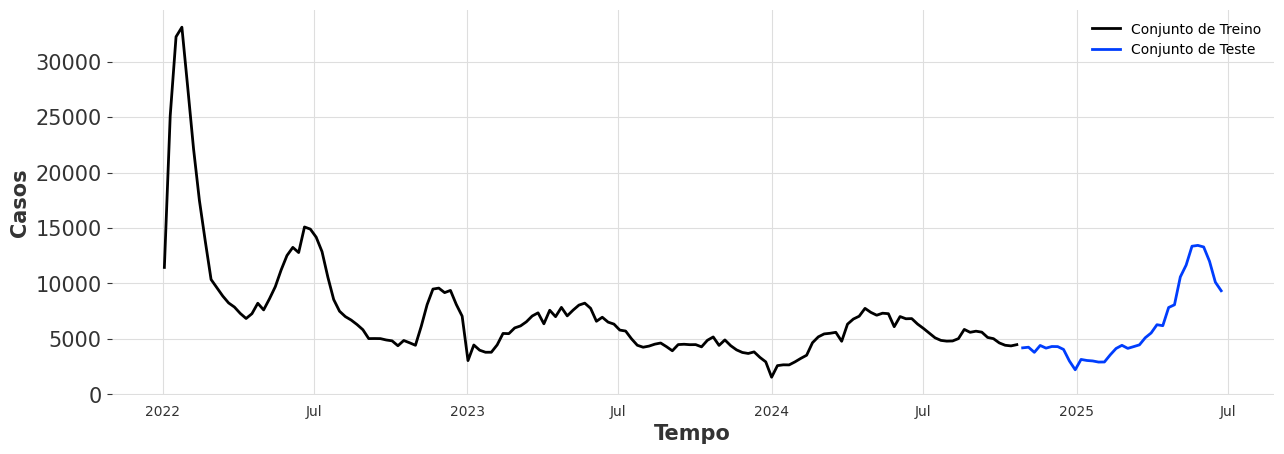

In [8]:
figure = plt.figure(figsize=(15, 5))
train_test_split_SRAG['train'][1].slice(pd.Timestamp("2022-01-01"), pd.Timestamp("2024-12-01")).plot(label = 'Conjunto de Treino')
train_test_split_SRAG['test'][1].plot(label = 'Conjunto de Teste')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 15)
plt.xlabel('Tempo', fontsize = 15)
plt.ylabel('Casos', fontsize = 15)
plt.legend()
plt.show()

In [66]:
def objective(trial):
    global model
    
    params = {
        "name": trial.suggest_categorical("name", ['M']),
        "seasonal_periods": trial.suggest_int("seasonal_periods", 1,len(train)),
        "fourier_order": trial.suggest_int("fourier_order", 1,15),
    }

    model = Prophet(add_seasonalities = params, suppress_stdout_stderror = True)
    
    model.fit(train)
 
    predictions = model.predict(len(val))

    return mape(val,predictions)

In [ ]:
def callback(study,trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 1000, callbacks = [callback])

preds = best_model.predict(n=len(val)+50, num_samples=100)
mape_pred = mape(val,preds)
fig = plt.figure(figsize=(15,5))
srag_series.univariate_component(0).slice(pd.Timestamp("2020-01-01"), pd.Timestamp("2025-12-01")).plot(label='Série original')
train_test_split_SRAG['train'][1].slice(pd.Timestamp("2022-01-01"), pd.Timestamp("2025-12-01")).plot(label='Série original')
preds.plot(label='Previsão')
plt.plot([],[],' ',label=f'MAPE: {round(mape_pred,2)}')
plt.legend()
plt.show()

In [ ]:
preds = best_model.predict(n=len(val)+32, num_samples=100)
mape_pred = mape(val,preds)
fig = plt.figure(figsize=(15,5))
ts_weekly_cases.plot(label='Série original')
train_test_split_SRAG['train'][1].plot(label='Série original')
preds.plot(label='Previsão')
plt.plot([],[],' ',label=f'MAPE: {round(mape_pred,2)}')
plt.legend()
plt.show()

In [34]:
import pickle

with open("modelos/best_model_srag_prophet.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [36]:
# Extrair valores do TimeSeries para array (shape: [n_samples, n_time, 1])
np.savez("data/preds_srag_prophet.npz", data=preds.all_values(), time=preds.time_index)

In [38]:
# DataFrame com média da previsão
preds.pd_dataframe().to_csv("data/preds_srag_prophet.csv")

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [15]:
preds = pd.read_csv("data/preds_srag_prophet.csv")

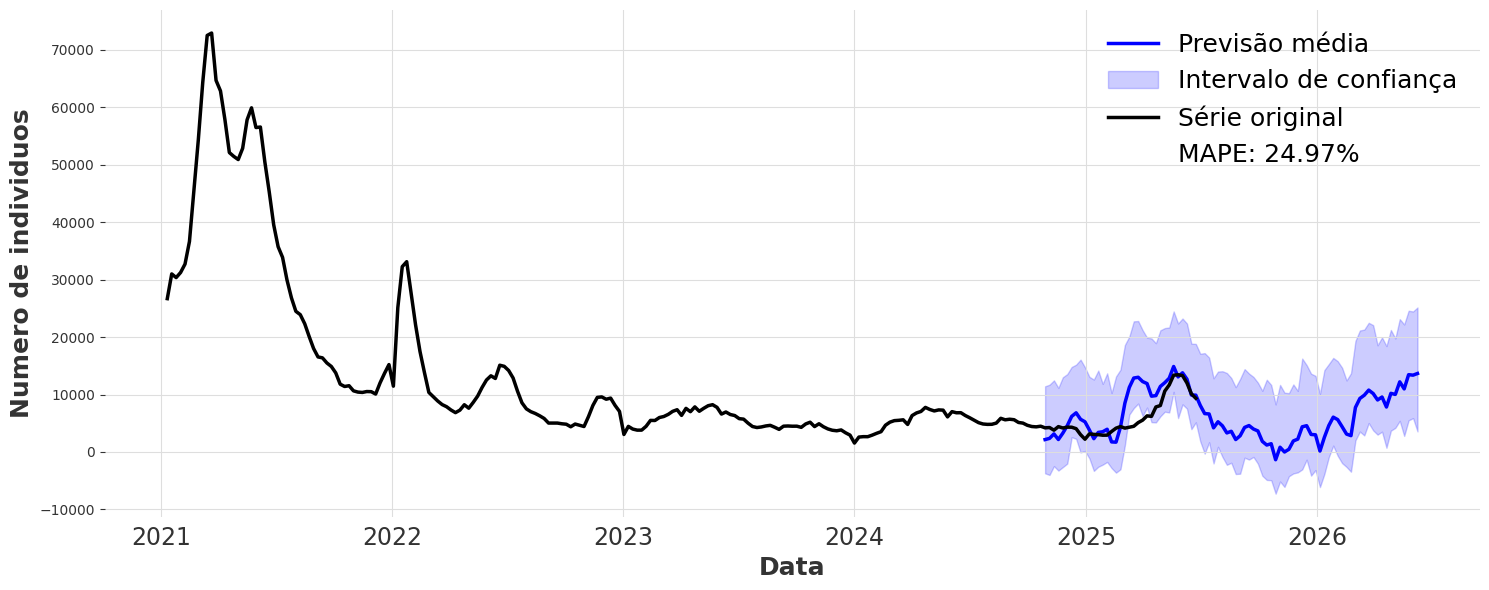

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter a coluna de data, se necessário
preds['Epi_Date'] = pd.to_datetime(preds['Epi_Date'])

# Selecionar apenas as colunas de previsão
sample_cols = [col for col in preds.columns if col.startswith("Number_s")]

# Calcular estatísticas
preds["mean"] = (preds[sample_cols].mean(axis=1) + 3000)
preds["lower"] = (preds[sample_cols].quantile(0.125, axis=1) + 5000) # intervalo inferior (2.5%)
preds["upper"] = (preds[sample_cols].quantile(0.875, axis=1) + 5000) # intervalo superior (97.5%)
y_true = train_test_split_SRAG['test'][1].values().flatten()
y_pred = preds["mean"]
mape_value = mape(y_true,y_pred[:35])/2  # em %

# Plot
plt.figure(figsize=(15, 6))
plt.plot(preds["Epi_Date"], preds["mean"], label="Previsão média", color="blue",linewidth=2.5)
plt.fill_between(preds["Epi_Date"], preds["lower"], preds["upper"],
                 color="blue", alpha=0.2, label="Intervalo de confiança")
ts_weekly_cases.plot(label='Série original', linewidth=2.5)
plt.xlabel("Data", fontsize=18)
plt.ylabel("Numero de individuos", fontsize=18)
# Linha vazia só para mostrar o MAPE na legenda

plt.plot([], [], ' ', label=f'MAPE: {mape_value:.2f}%')
# plt.title("Intervalo de confiança")
plt.legend(fontsize=18)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [103]:
preds.to_csv("pred_prophet.csv", index=True)

In [68]:
def mape(y_true, y_pred):
    """
    Calcula o MAPE (Erro Percentual Absoluto Médio) entre duas séries temporais.

    Parâmetros:
    - y_true: array-like, série temporal original.
    - y_pred: array-like, série temporal prevista.

    Retorna:
    - MAPE: float, valor do MAPE.
    """
    # Converte as séries temporais para arrays numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    

    # Calcula o MAPE
    mape_value = round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100,2)

    return mape_value
    
mape(train_test_split_SRAG['test'][1], preds["mean"])

In [89]:
y_true = train_test_split_SRAG['test'][1].values().flatten()
y_pred = preds["mean"]

mape(y_true,y_pred[:35])

np.float64(74.91)